In [ ]:
!unzip "./data.zip"

In [12]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pandas as pd
from aux import ImagesMRIDataset, split_for_cross_validation, get_training_testing_data, plot_data, get_data_distribution, split_traing_data

In [3]:
SIZE = (50, 50)
train_transform = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),  
    A.RandomGamma(gamma_limit=(80, 120), p=1.0),
    A.AdvancedBlur(blur_limit=(3, 5), p=0.5),  
    A.CLAHE(clip_limit=5.0, tile_grid_size=(8, 8), p=1.0),
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

simple_transformations = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def compute_transformations(image):
    image = train_transform(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)
    
def test_transformation(image):
    image = simple_transformations(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)


In [13]:
def training_loop(model, criterion, optimizer, dataloader, batch_size):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  current_training_loss = 0
  all_train_labels, all_train_preds = [], []
  model.train()
  for idx, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.to(device)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_training_loss += loss.item()
    all_train_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())
  return current_training_loss / dataloader.__len__() / batch_size, all_train_preds, all_train_labels


def validation_loop(model, criterion, dataloader, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_val_labels, all_val_preds = [], [],
    current_validation_loss = 0
    model.eval()
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        output = output.to(device)
        loss = criterion(output, labels)
        current_validation_loss += loss.item()
        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(output.argmax(dim=1).cpu().numpy())
    return current_validation_loss / dataloader.__len__() / batch_size,  all_val_preds, all_val_labels

def train_model(model, epochs, training_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, batch_size):
  training_loss = np.zeros(shape=(epochs,))
  validation_loss = np.zeros(shape=(epochs,))
  training_accuracy = np.zeros(shape=(epochs,))
  validation_accuracy = np.zeros(shape=(epochs,))
  for i in range(epochs):
    Tloss, train_pred, train_labels = training_loop(model, criterion, optimizer, training_dataloader, batch_size)
    Vloss, all_val_preds, all_val_labels = validation_loop(model, criterion, validation_dataloader, batch_size)
    lr_scheduler.step(Vloss)
    time.sleep(2)
    training_loss[i] = Tloss
    validation_loss[i] = Vloss
    training_accuracy[i] = accuracy_score(train_pred, train_labels)
    validation_accuracy[i] = accuracy_score(all_val_labels, all_val_preds)
    if (np.argmax(validation_accuracy) == i):
      print(f"best model found at {i}")
      # torch.save(model.state_dict(), "./best_model.pth")
    print(f"{i} is ready")
    if (i == epochs -1):
      print("termina aici")
      # torch.save(model.state_dict(), "./model.pth")
  return training_loss, validation_loss, training_accuracy, validation_accuracy

def test_model(model, dataloader, criterion, batch_size):
    _, preds, labels = validation_loop(model, criterion, dataloader, batch_size)
    precision = precision_score(preds, labels, average='macro') 
    recall = recall_score(preds, labels, average='macro')
    f1 = f1_score(preds, labels, average='macro')
    acc = accuracy_score(preds, labels)
    return precision, recall, f1, acc, confusion_matrix(preds, labels)


In [14]:
EPOCHS = 15
BATCH_SIZE = 10
WIDTH = 8
FACTOR = 4
LR = 1e-4
DECAY = 1e-4
PATIENCE = 2

def get_parameters(model):
  criterion = torch.nn.NLLLoss(reduction="sum")
  optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY)
  lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, threshold=1e-4, 
                                   patience=PATIENCE)
  return criterion, optimizer, lr_scheduler


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.width1 = WIDTH
        self.conv1 = nn.Conv2d(3, self.width1, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(self.width1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width2 = self.width1 * FACTOR
        self.conv2 = nn.Conv2d(self.width1, self.width2, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(self.width2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width3 = self.width2 * FACTOR
        self.conv3 = nn.Conv2d(self.width2, self.width3, kernel_size=(5, 5))
        self.bn3 = nn.BatchNorm2d(self.width3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width4 = self.width3 * FACTOR
        self.conv4 = nn.Conv2d(self.width3, self.width4, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(self.width4)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.width4, self.width3),
            nn.Dropout(p=0.3),
            nn.Linear(self.width3, self.width2),
            nn.Dropout(p=0.3),
            nn.Linear(self.width2, 4),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x : torch.tensor):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.relu(self.bn3(self.conv3(x))))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.avgpool(x)
        return self.classification_layer(x)


In [15]:
def save_plot(list1, list2, label1, label2, path, title):
    # loss_dir = os.path.dirname(path)
    # if loss_dir and not os.path.exists(loss_dir):
    #     os.makedirs(loss_dir)
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(list1) + 1), y=list1, label=label1, marker='o')
    sns.lineplot(x=range(1, len(list2) + 1), y=list2, label=label2, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, format="png")

def save_matrix(matrix, path):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1, 2, 3])
    cm_display.plot()
    plt.tight_layout()
    plt.savefig(path, format='png')
    plt.close()
    

def cross_validation_training_one_model(data_chunks : list, test_data : list, K : int, current : int):
    training_data = []
    for idx, chunk in enumerate(data_chunks):
        if (idx == current):
            continue
        training_data += chunk
    training_dataloader = DataLoader(ImagesMRIDataset(training_data, transformations=compute_transformations), batch_size=BATCH_SIZE, shuffle=True)
    validation_dataloader = DataLoader(ImagesMRIDataset(data_chunks[current], transformations=test_transformation), batch_size=BATCH_SIZE, shuffle=True)
    model = Net()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion, optimizer, lr_scheduler = get_parameters(model)
    training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, EPOCHS,
        training_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, BATCH_SIZE)
    save_plot(training_loss, validation_loss, "Train Loss", "Validation Loss", 
              f"./images/loss_model{current}.png", f"Loss model{current}")
    save_plot(training_accuracy, validation_accuracy, "Train Accuracy", "Validation Accuracy", 
          f"./images/accuracy_model{current}.png", f"Accuracy model{current}")
    return model, criterion

def compute_cross_validation(data_chunks, test_info, K):
    info_test = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
    info_validation = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
    testing_dataloader = DataLoader(ImagesMRIDataset(test_info, transformations=test_transformation), batch_size=BATCH_SIZE, shuffle=True)
    for i in range(K):
        validation_dataloader = DataLoader(ImagesMRIDataset(data_chunks[i], transformations=test_transformation), batch_size=BATCH_SIZE, shuffle=True)
        model, criterion = cross_validation_training_one_model(data_chunks, test_info, K, i)
        precision, recall, f1, acc, mat = test_model(model, testing_dataloader, criterion, BATCH_SIZE)
        save_matrix(mat, f"./images/confusion_matrix{i}.png")
        info_test["precision"].append(precision)
        info_test["accuracy"].append(acc)
        info_test["recall"].append(recall)
        info_test["f1Score"].append(f1)
        precision, recall, f1, acc, mat = test_model(model, validation_dataloader, criterion, BATCH_SIZE)
        info_validation["precision"].append(precision)
        info_validation["accuracy"].append(acc)
        info_validation["recall"].append(recall)
        info_validation["f1Score"].append(f1)
    return pd.DataFrame.from_dict(info_validation, "columns"), pd.DataFrame.from_dict(info_test, "columns")

In [16]:
training_info, test_info = get_training_testing_data()
training_info, validation_info = split_traing_data(training_info, 0.2)

training_dataloader = DataLoader(ImagesMRIDataset(training_info, transformations=compute_transformations), batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(ImagesMRIDataset(validation_info, transformations=test_transformation), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader =  DataLoader(ImagesMRIDataset(test_info, transformations=test_transformation), batch_size=BATCH_SIZE, shuffle=True)

best model found at 0
0 is ready
best model found at 1
1 is ready
best model found at 2
2 is ready
3 is ready
best model found at 4
4 is ready
5 is ready
best model found at 6
6 is ready
best model found at 7
7 is ready
8 is ready
9 is ready
best model found at 10
10 is ready
11 is ready
12 is ready
13 is ready
best model found at 14
14 is ready
termina aici


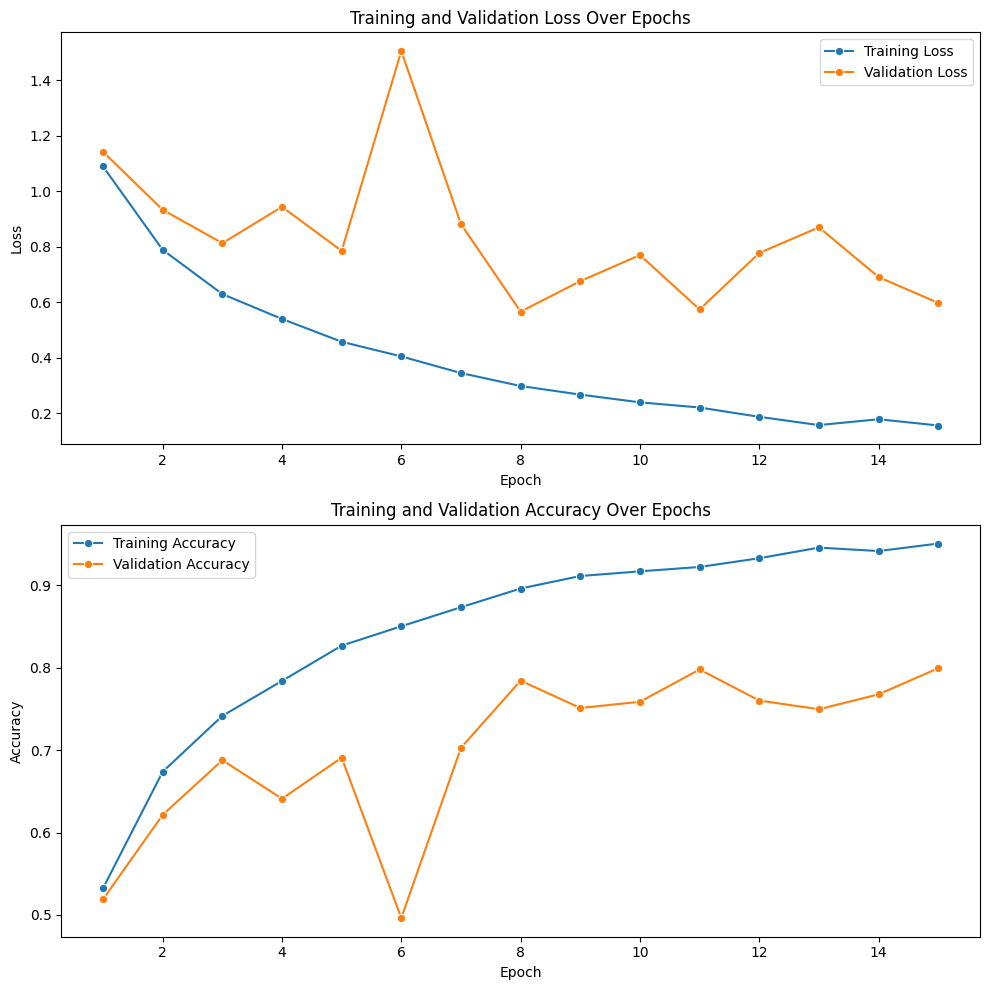

acuratete: 0.700507614213198


In [17]:
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
    
criterion, optimizer, lr_scheduler = get_parameters(model)
training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, EPOCHS,
    training_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, BATCH_SIZE)
plot_data(training_loss, validation_loss, training_accuracy, validation_accuracy)
precision, recall, f1, acc, mat = test_model(model, test_dataloader, criterion, BATCH_SIZE)
print("acuratete:",  acc)

In [38]:
K = 5
training_info, test_info = get_training_testing_data()
data_chunks = split_for_cross_validation(training_info, K)
validation_info, test_results = compute_cross_validation(data_chunks, test_info, K)

best model found at 0
0 is ready
best model found at 1
1 is ready
best model found at 2
2 is ready
best model found at 3
3 is ready
4 is ready
5 is ready
6 is ready
7 is ready
8 is ready
best model found at 9
9 is ready
termina aici
best model found at 0
0 is ready
1 is ready


In [19]:
print(validation_info)
print(test_results)

   precision    recall   f1Score  accuracy
0   0.289862  0.243819  0.226710  0.253807
1   0.199305  0.108317  0.129918  0.192893
2   0.228602  0.378472  0.161503  0.236041
3   0.221613  0.260485  0.178162  0.215736
4   0.225225  0.192680  0.145997  0.230964
